%%html
<style>
div.input {
    display:none;
}
</style>

------------------

### Relatório Business






In [1]:
import pandas as pd
import numpy as np
from plot_helper import diag_corr, bars, lines, joint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
df_full = pd.read_pickle('../data/interim/ambev-final-dataset.pkl')
df_full = df_full[df_full.status_meta != 'nan'] # removendo o que nao é meta
df_full['target'] = df_full.groupby(
    ['id_funcionario', 'mes']).ating_mes.transform('mean') / 100

#### Será que os gestores influênciam as metas dos seus diretos?

Observando a distribuição dos cumprimentos de meta dos gestores e seus funcionários diretos foi observado uma total falta de correlação. Isso pode significar que os gestores realmente não influenciam seus funcionários no cumprimento da meta, mas tal afirmação deveria demandar mais evidência para ser levada a sério, talvez quando olhando a companhia como um todo essa comportamento não se fique explicito, mas quando observarmos metas especificas para áreas especificas fique mais claro. 

In [3]:
meta_funcionarios_gestor = df_full.groupby(['id_gestor']).target.agg('mean').reset_index()

In [4]:
meta_gestor = df_full.loc[df_full.id_funcionario.isin(meta_funcionarios_gestor.id_gestor.unique())].groupby('id_funcionario').target.agg('mean').reset_index()

In [5]:
meta_gestor.columns = ['id','meta_gestor']
meta_funcionarios_gestor.columns = ['id', 'meta_funcionarios']

In [6]:
metas_hiera = pd.merge(meta_gestor, meta_funcionarios_gestor, how='inner', on=['id'])

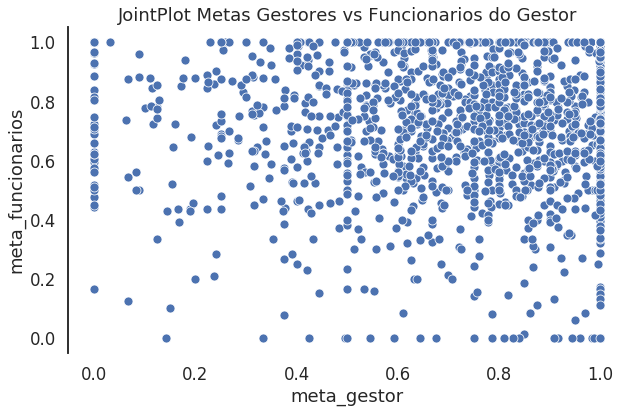

In [8]:
joint(metas_hiera.meta_gestor, metas_hiera.meta_funcionarios, 'JointPlot Metas Gestores vs Funcionarios do Gestor')

#### Acelera que o fim de ano vêm aí.

Observando os cumprimentos das metas por diferentes visões da empresa vemos que uma coisa é certa, chegando o fim do ano as metas são cumpridas em uma proporção muito maior. Destaque para a `Área Regional 3` por sua guinada impressionante.

In [10]:
local = 'area_regional'

In [11]:
# Pega os mais singificantes locais (com mais funcionários)

In [12]:
def visualiza_local(df, local, plot=True):
    ''' Cria visualizações temporais sobre o cumprimento da meta em categorias especificadas
    '''
    top_locais = df.groupby([local])['id_funcionario'].agg('nunique').sort_values(ascending=False)[:7].index
    por_local = df.groupby(['mes', local]).target.agg('mean').unstack()
    por_local = por_local.fillna(method='ffill').fillna(method='bfill')
    por_local = por_local.stack().reset_index(name='meta')
    por_local.loc[~por_local[local].isin(top_locais), local] = 'outros'

    if plot:
        lines(por_local.mes.astype(int), por_local.meta, por_local[local], 'Evolução Meta por ' + local)
    return por_local


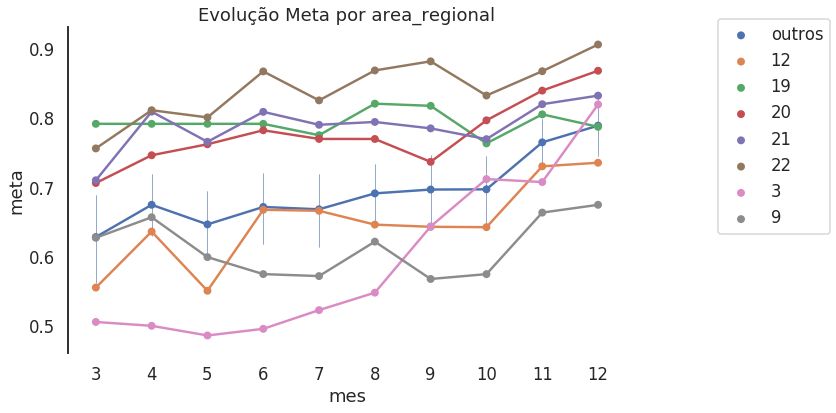

In [13]:
_ = visualiza_local(df_full, 'area_regional')

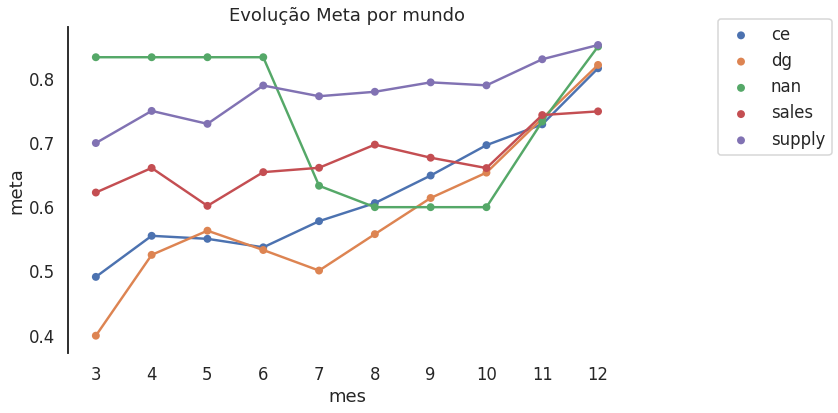

In [14]:
_ = visualiza_local(df_full, 'mundo')

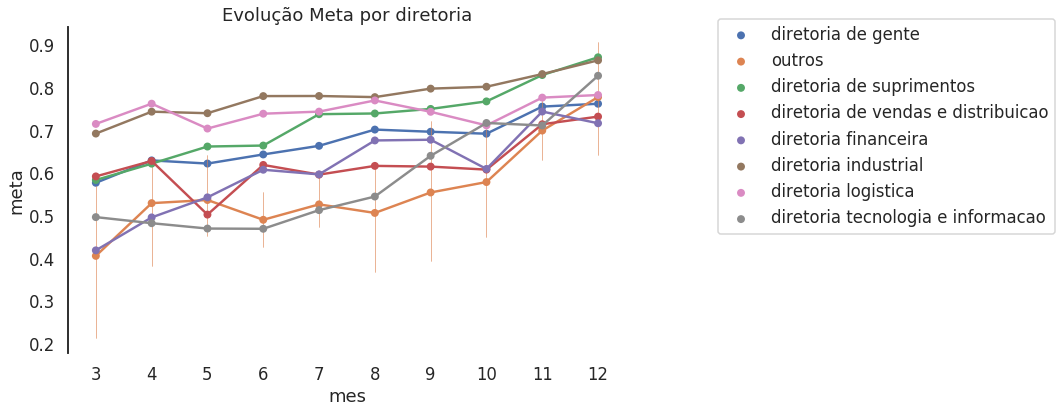

In [15]:
_ = visualiza_local(df_full, 'diretoria')

#### Nossas regiões se canibalizam?

Quando se pensa no tamanho da Ambev e seu Market-Share, é difícil achar que não haja canibalismo das vendas dos produtos. Observando os gráficos abaixo vemos que o canibalismo muito provavelmente existe e influência fortemente as metas dos funcionários das áreas que se afetam. Principalmente a `Área Regional 0` que tem uma correlação de metas negativa muito forte em relação as outras.

In [16]:
por_reg = df_full.groupby(['mes', 'area_regional']).target.agg('mean').unstack()

In [17]:
# Ajustando os nomes das colunas para conseguir ordernar
por_reg.columns = [format(int(x), '02d') for x in por_reg.columns.values]

In [18]:
# Criando matrix de correlação
por_reg = por_reg.reindex(sorted(por_reg.columns), axis=1)
corr = por_reg.corr()

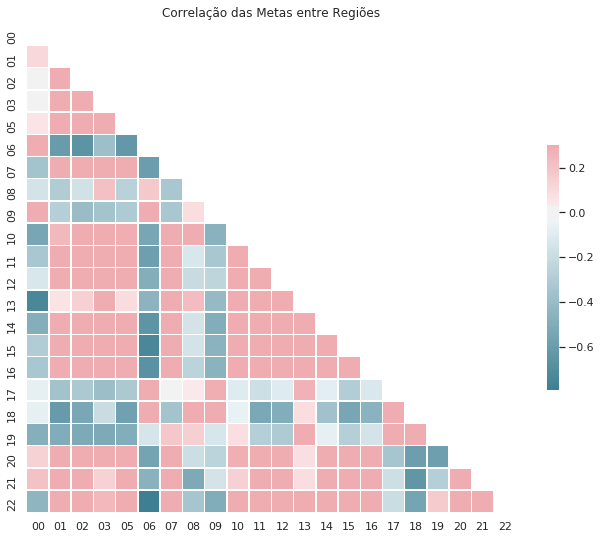

In [19]:
diag_corr(corr, 'Correlação das Metas entre Regiões')

In [20]:
smax = corr.columns.to_series() + ' -> ' + corr[corr<1].idxmax()
smin = corr.columns.to_series() + ' -> ' + corr.idxmin()
vmax = corr[corr<1].max()
vmin = corr.min()

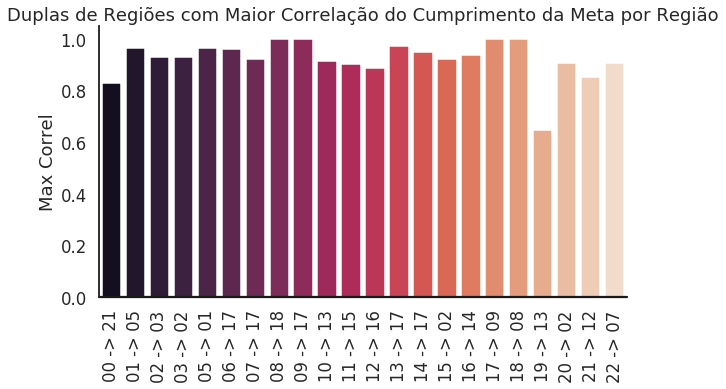

In [21]:
bars(smax, vmax, 'Max Correl', 'Duplas de Regiões com Maior Correlação do Cumprimento da Meta por Região')

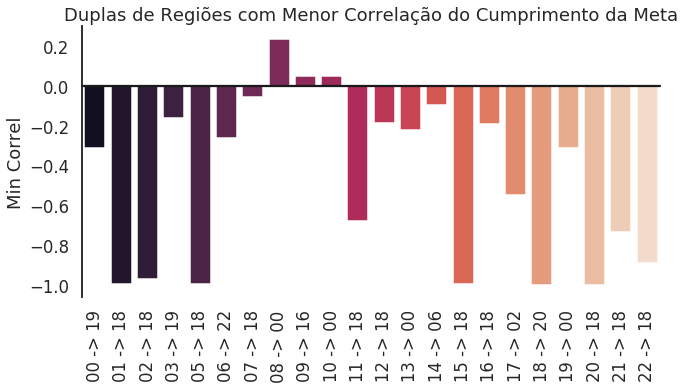

In [22]:
bars(smin, vmin, 'Min Correl', 'Duplas de Regiões com Menor Correlação do Cumprimento da Meta')